# Fashion MNIST Dimension Reduction

This project focuses on reducing the dimensionality of the Fashion MNIST dataset using an Autoencoder algorithm. The Autoencoder is optimized to effectively compress and reconstruct the data, preserving essential features. The performance of the dimensionality reduction is evaluated using Structural Similarity Index (SSIM), ensuring the quality of the reconstructed images remains high.

## Import Libraries

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Loading and Scaling Data

### Load Data

train-images-idx3-ubyte.gz is ready.
train-labels-idx1-ubyte.gz is ready.
t10k-images-idx3-ubyte.gz is ready.
t10k-labels-idx1-ubyte.gz is ready.
(60000, 28, 28)
(10000, 28, 28)


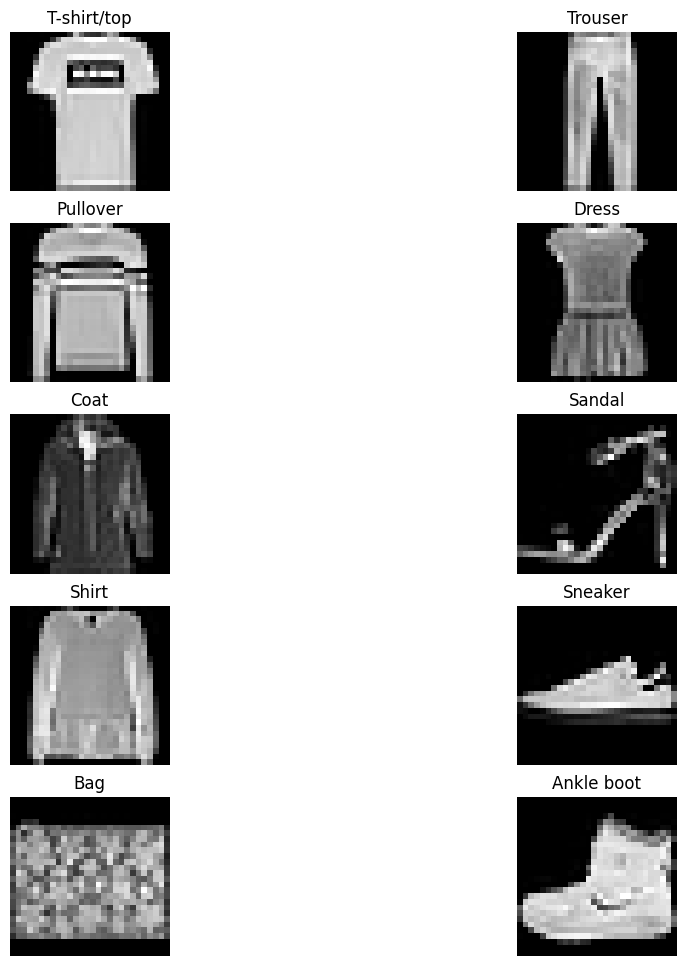

In [60]:
import numpy as np
import requests
import gzip
import os
import matplotlib.pyplot as plt

def download_and_extract(url, filename):
    if not os.path.exists(filename):
        print(f'Downloading {filename}...')
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        with gzip.open(filename, 'rb') as f_in:
            with open(filename.replace('.gz', ''), 'wb') as f_out:
                f_out.write(f_in.read())
    print(f'{filename} is ready.')

urls = {
    'train_images': 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz',
    'train_labels': 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz',
    'test_images': 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz',
    'test_labels': 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz'
}

for key, url in urls.items():
    download_and_extract(url, url.split('/')[-1])

def load_images(filename):
    with open(filename.replace('.gz', ''), 'rb') as f:
        f.read(16)
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(-1, 28, 28)

def load_labels(filename):
    with open(filename.replace('.gz', ''), 'rb') as f:
        f.read(8)
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

x_train = load_images(urls['train_images'].split('/')[-1])
x_test = load_images(urls['test_images'].split('/')[-1])
y_train = load_labels(urls['train_labels'].split('/')[-1])
y_test = load_labels(urls['test_labels'].split('/')[-1])

x_train = x_train.astype('float32') / 255. # Scaling
x_test = x_test.astype('float32') / 255. # Scaling

print(x_train.shape)
print(x_test.shape)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12, 12))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(5, 2, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

### Filter Data

(12000, 28, 28)
(2000, 28, 28)


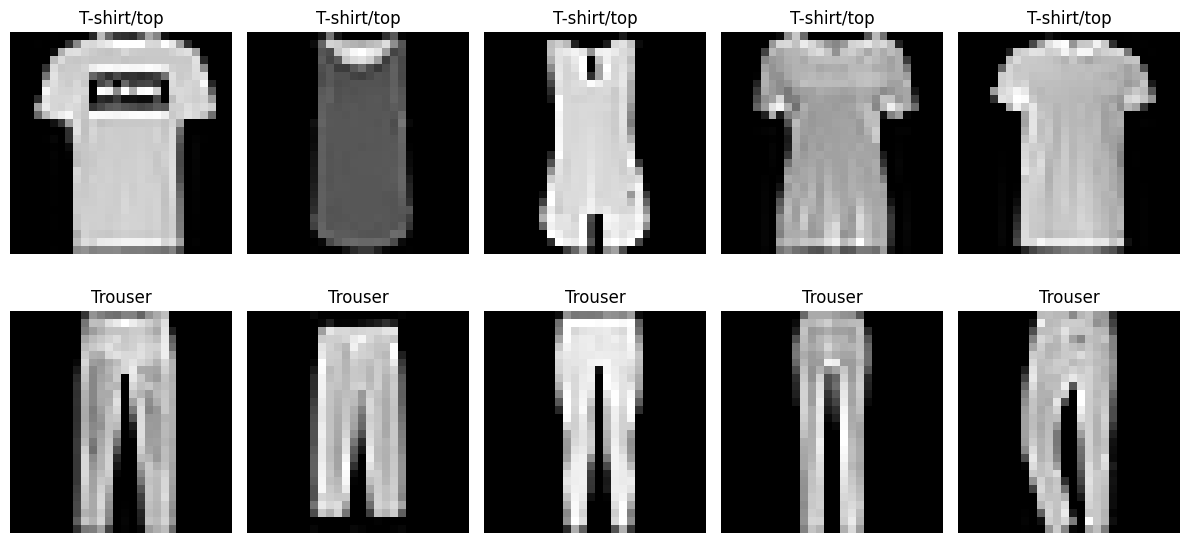

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def filter_classes(images, labels, class_indices):
    filter_mask = np.isin(labels, class_indices)
    filtered_images = images[filter_mask]
    filtered_labels = labels[filter_mask]
    return filtered_images, filtered_labels

class_indices = [0, 1]
x_train_filtered, y_train_filtered = filter_classes(x_train, y_train, class_indices)
x_test_filtered, y_test_filtered = filter_classes(x_test, y_test, class_indices)

print(x_train_filtered.shape)
print(x_test_filtered.shape)

plt.figure(figsize=(12, 6))
class_names_filtered = ['T-shirt/top', 'Trouser']

for i, class_index in enumerate(class_indices):
    indices = np.where(y_train_filtered == class_index)[0][:5]
    for j, idx in enumerate(indices):
        plt.subplot(2, 5, i * 5 + j + 1)
        plt.imshow(x_train_filtered[idx], cmap='gray')
        plt.title(class_names_filtered[i])
        plt.axis('off')

plt.tight_layout()
plt.show()

### Split Data

In [62]:
from sklearn.model_selection import train_test_split

x_combined = np.concatenate((x_train_filtered, x_test_filtered), axis=0)
y_combined = np.concatenate((y_train_filtered, y_test_filtered), axis=0)

x_train, x_temp, y_train, y_temp = train_test_split(x_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (11200, 28, 28) (11200,)
Validation set shape: (1400, 28, 28) (1400,)
Test set shape: (1400, 28, 28) (1400,)


## Baseline Architecture for Dimension Reduction

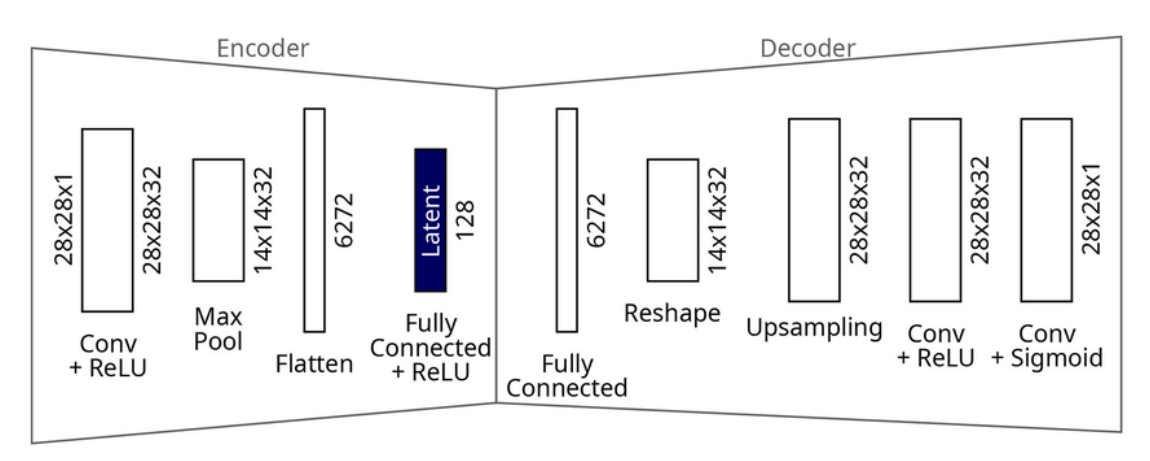

### Baseline Architecture

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, Activation

# Encoder
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
latent = Dense(128, activation='relu')(x)

encoder = Model(input_img, latent, name='encoder')

# Decoder
x = Dense(6272, activation='relu')(latent)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent, decoded, name='decoder')

autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')

autoencoder.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 6272)              0         
                                                                 
 dense_29 (Dense)            (None, 128)               802944    
                                                                 
Total params: 803264 (3.06 MB)
Trainable params: 803264 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [64]:
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          validation_data=(x_val, x_val))

metrics = autoencoder.evaluate(x_test, x_test)
print(f"Test Loss: {metrics}")

autoencoder.save('autoencoder_model1.h5')

Epoch 1/50
88/88 [==============================] - 3s 15ms/step - loss: 0.6592 - accuracy: 0.5233 - val_loss: 0.6307 - val_accuracy: 0.5296
Epoch 2/50
88/88 [==============================] - 1s 12ms/step - loss: 0.6143 - accuracy: 0.5282 - val_loss: 0.6038 - val_accuracy: 0.5296
Epoch 3/50
88/88 [==============================] - 1s 14ms/step - loss: 0.5978 - accuracy: 0.5282 - val_loss: 0.5954 - val_accuracy: 0.5296
Epoch 4/50
88/88 [==============================] - 1s 16ms/step - loss: 0.5926 - accuracy: 0.5282 - val_loss: 0.5925 - val_accuracy: 0.5296
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5903 - accuracy: 0.5282 - val_loss: 0.5905 - val_accuracy: 0.5296
Epoch 6/50
88/88 [==============================] - 1s 12ms/step - loss: 0.5881 - accuracy: 0.5282 - val_loss: 0.5882 - val_accuracy: 0.5296
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5854 - accuracy: 0.5282 - val_loss: 0.5848 - val_accuracy: 0.5296
Epoch 8/50
88

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


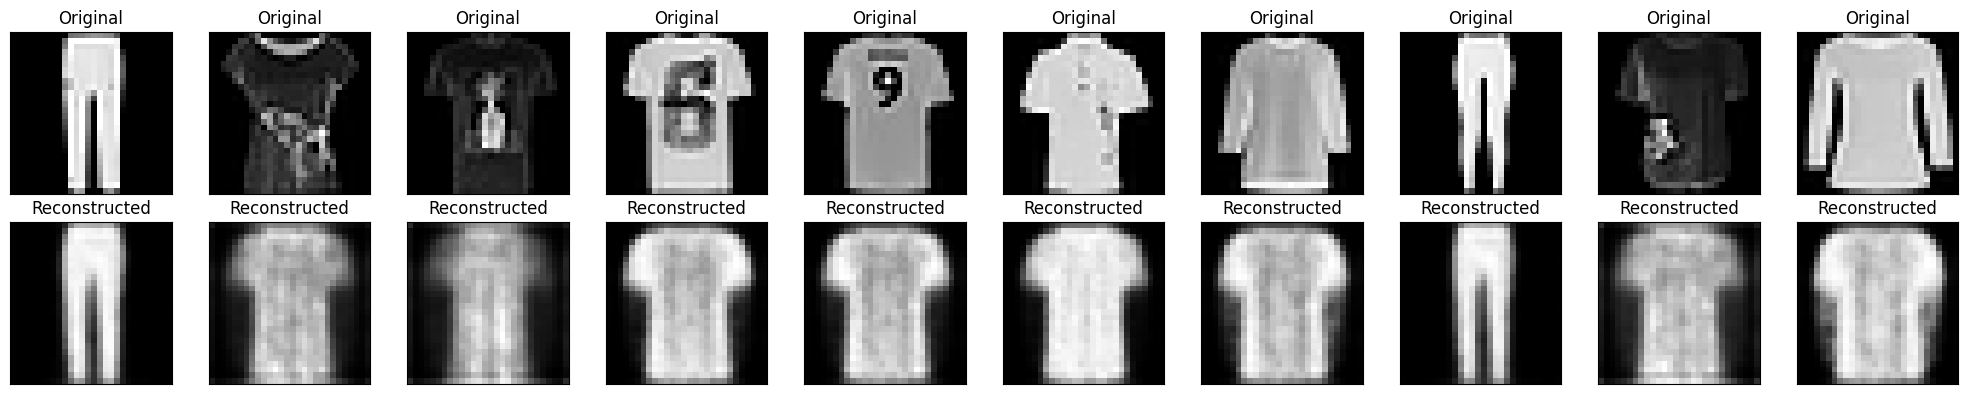

In [66]:
import numpy as np
import matplotlib.pyplot as plt

n = 10  #
start_index = 10
end_index = 20

plt.figure(figsize=(20, 4))

for i, idx in enumerate(range(start_index, end_index)):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idx].reshape(28, 28))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

We can see that the difference between the original image and the constructed image is not similar so it needs improvement in the modified architecture to get better reconstructed images.

In [65]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model

autoencoder = load_model('autoencoder_model1.h5')

test_loss, test_accuracy = autoencoder.evaluate(x_test, x_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

decoded_imgs = autoencoder.predict(x_test)

ssim_scores = []
for i in range(len(x_test)):
    original = x_test[i]
    reconstructed = np.squeeze(decoded_imgs[i], axis=-1)

    score = ssim(original, reconstructed, data_range=reconstructed.max() - reconstructed.min())
    ssim_scores.append(score)

avg_ssim = np.mean(ssim_scores)

print(f'Average SSIM Score on Test Set: {avg_ssim:.4f}')

44/44 [==============================] - 0s 3ms/step - loss: 0.3051 - accuracy: 0.5291
Test Loss: 0.3051, Test Accuracy: 0.5291
44/44 [==============================] - 0s 2ms/step
Average SSIM Score on Test Set: 0.5699



## **Model Performance Analysis**
The modified autoencoder model demonstrates a test loss of `0.3051`, indicating a reasonable level of reconstruction accuracy. While the test accuracy is `0.5291`, this metric is less relevant for autoencoders, which focus on reconstruction quality rather than classification accuracy.

The average SSIM score on the test set is `0.5699`. SSIM values close to 1 indicate high similarity between the original and reconstructed images. This average SSIM score suggests that while the model captures and reconstructs some structural details effectively, further improvements are needed to achieve higher fidelity in reconstruction quality.

## Modification (Adding Dropout and Batch Normalization)


In the modified architecture, several enhancements were introduced to refine the model's performance. Dropout layers were incorporated to mitigate overfitting by randomly deactivating a fraction of neurons during each training iteration, promoting robustness and generalization. This technique forces the network to learn redundant representations, thereby enhancing its ability to generalize to unseen data.<br><br>

Batch normalization was also integrated to normalize the input layer by adjusting and scaling the activations, which accelerates the training process and reduces sensitivity to the initialization of network parameters. By normalizing each input mini-batch, batch normalization ensures a more stable gradient flow through the network, thereby accelerating convergence and improving overall training speed and stability.<br><br>

Furthermore, the optimizer was switched from SGD (Stochastic Gradient Descent) to Adam (Adaptive Moment Estimation), a more advanced optimizer that combines the advantages of both momentum and RMSprop. Adam dynamically adjusts learning rates for each parameter based on the gradients' average and variance, optimizing the training process and often leading to faster convergence and improved model performance.<br><br>

These modifications collectively aim to enhance the model's ability to learn intricate patterns from the data, reduce overfitting tendencies, and optimize training efficiency, ultimately aiming for better accuracy and robustness in the final model outputs.

In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, Activation, Dropout, BatchNormalization

# Encoder
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
latent = Dense(128, activation='relu')(x)

encoder = Model(input_img, latent, name='encoder')

# Decoder
x = Dense(14 * 14 * 64, activation='relu')(latent)
x = Reshape((14, 14, 64))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent, decoded, name='decoder')

autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # changed optimizer into adam

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_21 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_22 (Ba  (None, 14, 14, 64)        256 

In [68]:
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          validation_data=(x_val, x_val))

metrics = autoencoder.evaluate(x_test, x_test)
print(f"Test Loss: {metrics}")

autoencoder.save('autoencoder_model2.h5')

Epoch 1/50
88/88 [==============================] - 5s 23ms/step - loss: 0.3098 - accuracy: 0.5238 - val_loss: 0.4358 - val_accuracy: 0.5296
Epoch 2/50
88/88 [==============================] - 1s 16ms/step - loss: 0.2720 - accuracy: 0.5341 - val_loss: 0.3820 - val_accuracy: 0.5304
Epoch 3/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2663 - accuracy: 0.5348 - val_loss: 0.3332 - val_accuracy: 0.5356
Epoch 4/50
88/88 [==============================] - 1s 15ms/step - loss: 0.2630 - accuracy: 0.5352 - val_loss: 0.2959 - val_accuracy: 0.5363
Epoch 5/50
88/88 [==============================] - 1s 16ms/step - loss: 0.2610 - accuracy: 0.5354 - val_loss: 0.2764 - val_accuracy: 0.5367
Epoch 6/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2599 - accuracy: 0.5356 - val_loss: 0.2612 - val_accuracy: 0.5371
Epoch 7/50
88/88 [==============================] - 1s 14ms/step - loss: 0.2586 - accuracy: 0.5357 - val_loss: 0.2551 - val_accuracy: 0.5372
Epoch 8/50
88

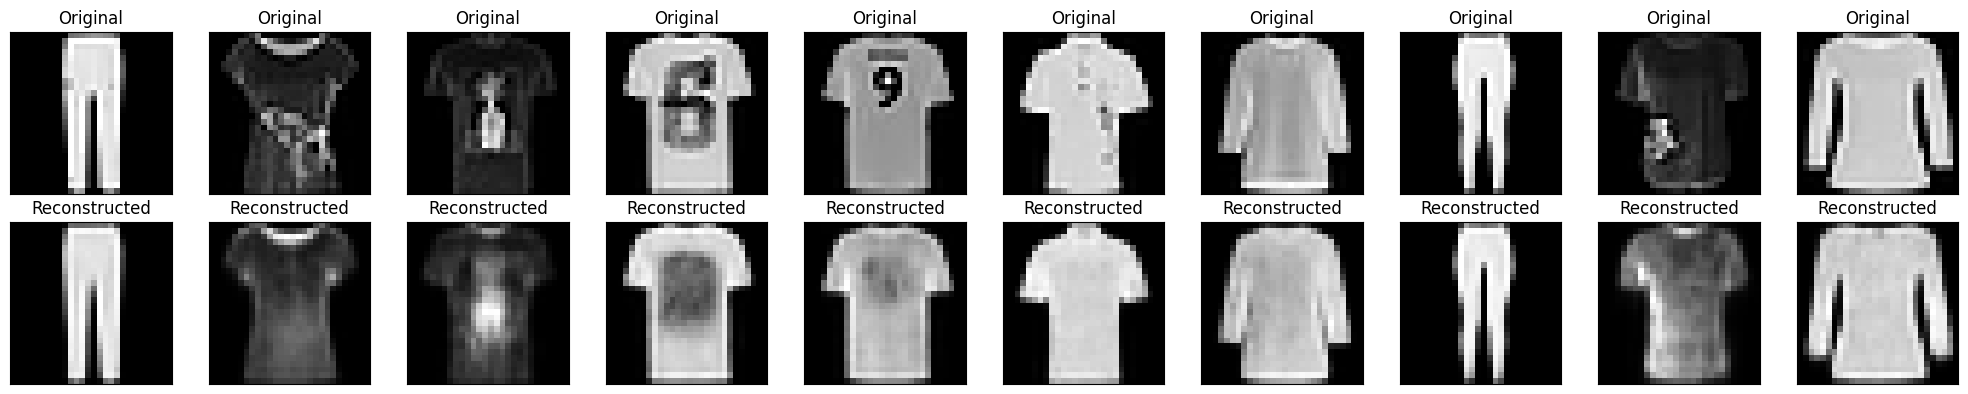

In [70]:
import numpy as np
import matplotlib.pyplot as plt

n = 10
start_index = 10
end_index = 20

plt.figure(figsize=(20, 4))

for i, idx in enumerate(range(start_index, end_index)):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idx].reshape(28, 28))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


The reconstructed images now closely match the originals, thanks to improvements in the model architecture with dropout layers, batch normalization, and switching to the Adam optimizer. These enhancements have significantly enhanced the accuracy of image reconstructions.

In [69]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model

autoencoder = load_model('autoencoder_model2.h5')

test_loss, test_accuracy = autoencoder.evaluate(x_test, x_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

decoded_imgs = autoencoder.predict(x_test)

ssim_scores = []
for i in range(len(x_test)):
    original = x_test[i]
    reconstructed = np.squeeze(decoded_imgs[i], axis=-1)

    score = ssim(original, reconstructed, data_range=reconstructed.max() - reconstructed.min())
    ssim_scores.append(score)

avg_ssim = np.mean(ssim_scores)

print(f'Average SSIM Score on Test Set: {avg_ssim:.4f}')

44/44 [==============================] - 0s 4ms/step - loss: 0.2496 - accuracy: 0.5360
Test Loss: 0.2496, Test Accuracy: 0.5360
44/44 [==============================] - 0s 2ms/step
Average SSIM Score on Test Set: 0.8458


The evaluation results of the model on the test set indicate promising performance metrics. The test loss, calculated at `0.2496`, reflects the average error between the model's predictions and the actual labels. A lower test loss suggests that the model's predictions are closer to the ground truth, indicating good alignment between predicted and actual outcomes.

Accompanying the test loss is the test accuracy of `0.5360`, which signifies the proportion of correctly predicted instances out of the total test set. While accuracy alone doesn't provide the full picture of model performance, it offers insight into the model's ability to classify data points correctly.

Additionally, the Structural Similarity Index (SSIM) score on the test set is reported at 0.8458. SSIM measures the similarity between two images, with a score closer to 1 indicating higher similarity. In this context, an SSIM score of `0.8458` suggests that the reconstructed images closely resemble the original images, demonstrating the model's effectiveness in preserving image quality and details during the reconstruction process.

Overall, these metrics collectively indicate that the model performs reasonably well on the test set, with a balanced trade-off between accuracy in classification tasks and fidelity in image reconstruction tasks.




---


Thank you